- Having a family
- Having a spouse
- Ship deck
- Class
- Age
- Gender
- Expensive tickets vs cheap tickets

In [569]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.feature_selection import SelectFromModel
import seaborn as sns

pd.options.display.max_colwidth = 0
pd.options.display.max_columns = 0
plt.rcParams['figure.figsize'] = 18, 6

In [509]:
train_types = {
    'Age': np.float32,
    'Cabin': str,
    'Embarked': str,
    'Fare': np.float32,
    'Name': str,
    'Parch': np.int8,
    'Pclass': np.int8,
    'Sex': str,
    'SibSp': np.int8,
    'Survived': np.int8,
    'Ticket': str
}

train = pd.read_csv('data/train.csv', index_col='PassengerId', dtype=train_types)
test = pd.read_csv('data/test.csv', index_col='PassengerId', dtype=train_types)
full = pd.concat([train, test])
full.columns = full.columns.str.lower()
full.index.rename('pid', inplace=True)
full.head()

,age,cabin,embarked,fare,name,parch,pclass,sex,sibsp,survived,ticket
pid,,,,,,,,,,,
1,22.0,NaN,S,7.250000,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171
2,38.0,C85,C,71.283302,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",0,1,female,1,1.0,PC 17599
3,26.0,NaN,S,7.925000,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282
4,35.0,C123,S,53.099998,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803
5,35.0,NaN,S,8.050000,"Allen, Mr. William Henry",0,3,male,0,0.0,373450


In [510]:
full.isnull().sum()

age         263 
cabin       1014
embarked    2   
fare        1   
name        0   
parch       0   
pclass      0   
sex         0   
sibsp       0   
survived    418 
ticket      0   
dtype: int64

In [592]:
full[['surname','title']] = full.name.str.extract('(\w+), (.*?)\..*', expand=True)
full['title'] = full['title'].replace('Ms', 'Miss')
to_replace = list(set(full['title'].tolist()).difference(['Mr', 'Miss', 'Mrs', 'Master']))
full['title'] = full['title'].replace(to_replace, 'Other')

full['famsize'] = full['sibsp'] + full['parch'] + 1
full['deck'] = full['cabin'].str.extract('([A-Z]).*',expand=True)
full['deck'].fillna('X', inplace=True)
full.loc[:, 'child'] = 0
full.loc[full['age'] < 18, 'child'] = 1

full['embarked'].fillna('S', inplace=True)
full['fare'].fillna(8.05, inplace=True)

median_age = full.groupby('title')['age'].median().to_dict()
full.loc[full['age'].isnull(), 'age'] = full.loc[full['age'].isnull(), 'title'].map(median_age)

full['even_cabin'] = full['cabin'].str.extract('[A-Z]([0-9]+)', expand=True).fillna(0).astype(int) % 2
full['cabin_num'] = full['cabin'].str.extract('[A-Z]([0-9]+)', expand=True).fillna(0).astype(int)
full['gender'] = full['sex'].map({'male':1, 'female':0})
full['npass'] = full.groupby('ticket')['ticket'].transform('count')
full['fare_adj'] = full['fare'] / full['npass']
full['alone'] = 0
full.loc[full['famsize'] == 1, 'alone'] = 1
full.head()

,age,cabin,embarked,fare,name,parch,pclass,sex,sibsp,survived,ticket,surname,title,famsize,deck,child,gender,npass,fare_adj,cabin_num,even_cabin,alone
pid,,,,,,,,,,,,,,,,,,,,,,
1,22.0,NaN,S,7.250000,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171,Braund,Mr,2,X,0,1,1,7.250000,0,0,0
2,38.0,C85,C,71.283302,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",0,1,female,1,1.0,PC 17599,Cumings,Mrs,2,C,0,0,2,35.641651,85,1,0
3,26.0,NaN,S,7.925000,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282,Heikkinen,Miss,1,X,0,0,1,7.925000,0,0,1
4,35.0,C123,S,53.099998,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803,Futrelle,Mrs,2,C,0,0,2,26.549999,123,1,0
5,35.0,NaN,S,8.050000,"Allen, Mr. William Henry",0,3,male,0,0.0,373450,Allen,Mr,1,X,0,1,1,8.050000,0,0,1


In [593]:
full.isnull().sum()

age           0   
cabin         1014
embarked      0   
fare          0   
name          0   
parch         0   
pclass        0   
sex           0   
sibsp         0   
survived      418 
ticket        0   
surname       0   
title         0   
famsize       0   
deck          0   
child         0   
gender        0   
npass         0   
fare_adj      0   
cabin_num     0   
even_cabin    0   
alone         0   
dtype: int64

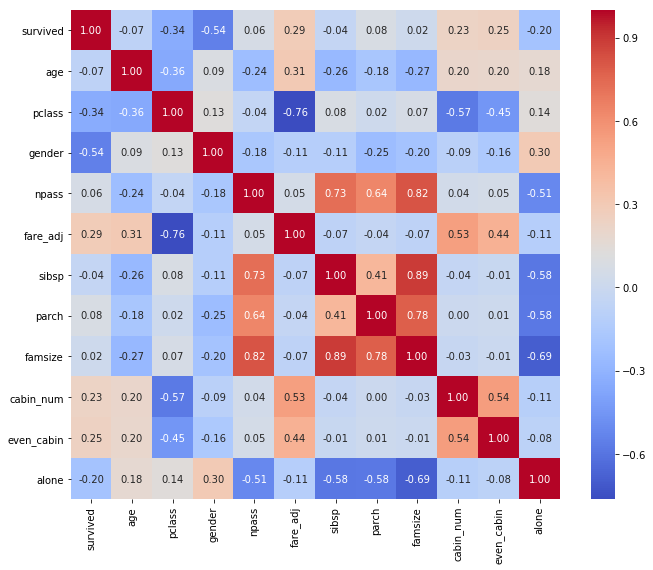

In [595]:
f, ax = plt.subplots(figsize=[11,9])
train = full[~full['survived'].isnull()]
sns.heatmap(
    train[['survived', 'age', 'pclass', 'gender', 'npass', 'fare_adj',
           'sibsp', 'parch', 'famsize', 'cabin_num', 'even_cabin',
           'alone']].corr(),
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    square=True
)
plt.show()

In [596]:
# ENCODE DECK AS ORDINAL, TICEKTGROUP SIZE

encoded = full.drop(['fare', 'cabin', 'name', 'surname', 'ticket', 'sex', 'sibsp', 'parch'], axis=1)
encoded = pd.get_dummies(encoded)

train = encoded[~encoded['survived'].isnull()]
train.head()

,age,pclass,survived,famsize,child,gender,npass,fare_adj,cabin_num,even_cabin,alone,embarked_C,embarked_Q,embarked_S,title_Master,title_Miss,title_Mr,title_Mrs,title_Other,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,deck_X
pid,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,22.0,3,0.0,2,0,1,1,7.250000,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,38.0,1,1.0,2,0,0,2,35.641651,85,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
3,26.0,3,1.0,1,0,0,1,7.925000,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,35.0,1,1.0,2,0,0,2,26.549999,123,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0
5,35.0,3,0.0,1,0,1,1,8.050000,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [597]:
y = train['survived']
x = train.drop('survived', axis=1)

seed = 10
clf = RandomForestClassifier(n_estimators=50, random_state=seed)
clf.fit(x, y)

scores = cross_val_score(clf, x, y, cv=5)
print('Score: {:.2f} +/- {:.2f}'.format(np.mean(scores), np.std(scores)))

Score: 0.82 +/- 0.03


In [598]:
parameter_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [2, 5, 8],
    'n_estimators': [50, 10],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
}
clf = ExtraTreesClassifier(n_jobs=2, random_state=seed)

grid_search = GridSearchCV(
    clf,
    scoring='accuracy',
    param_grid=parameter_grid,
    cv=3,
    n_jobs=2,
    verbose=1
)

grid_search.fit(x, y)
clf = grid_search.best_estimator_
parameters = grid_search.best_params_

print('Best score: {:.2f}'.format(grid_search.best_score_))
print('Best estimator: {}'.format(grid_search.best_estimator_))

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    8.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   34.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done 648 out of 648 | elapsed:  1.9min finished


Best score: 0.83
Best estimator: ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=8, max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=2,
           oob_score=False, random_state=10, verbose=0, warm_start=False)


In [601]:
features = list(zip(x.columns, np.transpose(clf.feature_importances_ * 100)))
features = pd.DataFrame(features, columns=['feature','importance']).sort_values('importance', ascending=False)
features['importance'] = features['importance'].astype(int)
features

,feature,importance
15,title_Mr,22
4,gender,17
1,pclass,7
16,title_Mrs,6
14,title_Miss,6
26,deck_X,4
5,npass,4
6,fare_adj,4
8,even_cabin,3
2,famsize,3


In [600]:
result = pd.DataFrame()
test = encoded[encoded['survived'].isnull()]
test = test.drop('survived', axis=1)
result = pd.DataFrame({'PassengerId': test.index.tolist()})
result['Survived'] = clf.predict(test).astype(int)
result.to_csv('submissions/submission.csv', index=False)